# size distribution example
Load basic packages

In [1]:
import size_distribution_class as sdc
import statistics

import pandas as pd
import pandas_bokeh
import numpy as np
from pylab import *
from scipy.optimize import curve_fit

from bokeh.io import output_file, output_notebook
from bokeh.models import DatetimeTickFormatter, ranges, Span, Label, Range1d, LinearAxis
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.palettes import linear_palette, Turbo256
from matplotlib import pyplot as plt
pd.set_option('plotting.backend', 'pandas_bokeh')
output_notebook(hide_banner=True)
from IPython.core.display import display, HTML



In [2]:
psd = sdc.singeFileProcess( verbose=True, analyze_color_name='white' )

Please select the directory with the source image tiles.
--------------------------------------------------
  5.8282 x 5.8282 nm/px
 Analysing pores_C3S 28d BIB 6KV 6h_005.tif
size: 11889.428316655109 x 9569.824164680238 nm / 2040 x 1642 px 
loaded psd csv
loaded cld csv


## Loaded image

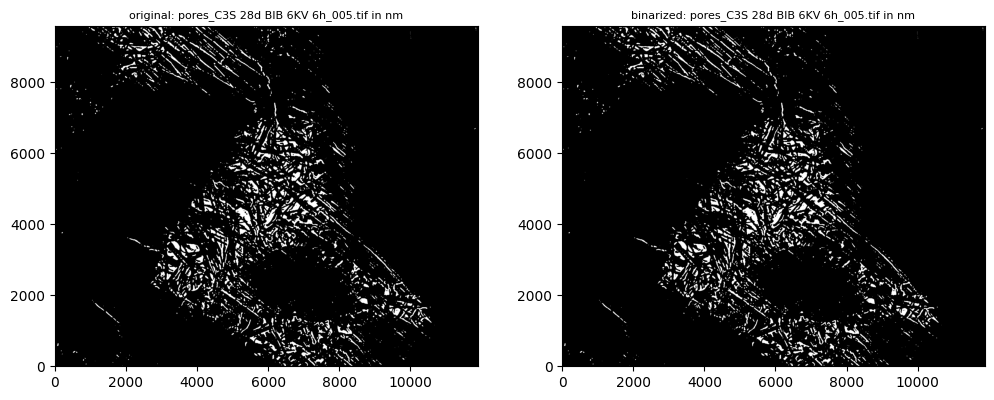

In [3]:

fig = plt.figure(figsize=(12,8), dpi= 100)
fig.add_subplot(1, 2, 1)
plt.imshow( psd.img, extent=[0,psd.get_scaled_width(),0,psd.get_scaled_height()], cmap='gray' );
plt.title('original: {} in {}'.format(psd.filename, psd.scaling['unit']), fontsize=8);
fig.add_subplot(1, 2, 2)
plt.imshow( psd.thresh_img, extent=[0,psd.get_scaled_width(),0,psd.get_scaled_height()], cmap='gray' );
plt.title('binarized: {} in {}'.format(psd.filename, psd.scaling['unit']), fontsize=8);

## Basic functions to generate the following diagrams

In [51]:
#https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
def smooth(x, window_len=7, window='hanning'):
    if window_len<3:
        return x

    if window_len % 2 == 0:
        window_len += 1
        print("Warning: 'window_len' has to be an odd number! Changing window size to {}".format(window_len))

    if isinstance(x, list):
        x = np.array(x)

    if x.ndim != 1:
        raise ValueError("smooth() only accepts 1 dimension arrays or lists.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        window = 'hanning'
        print("Warning: 'window' has to be one of the following: of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'. Switching to '{}'.".format(window))

    prepend_x = x[int((window_len-1)/2):0:-1] #x[window_len-1:0:-1]
    append_x = x[-2:-int(2+(window_len-1)/2):-1] #x[-2:-window_len-1
    s = np.r_[prepend_x, x, append_x]
    
    if window == 'flat': #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    y = np.convolve(w/w.sum(), s, mode='valid')
    return y

def get_X_List( values ):
    value_cnt = len(values)
    x_range = list(range(value_cnt))
    x_range.pop(0)
    x_range.append(value_cnt)
    return x_range

def get_x(x, c):
    c_len = len(c)
    if c_len == 1:
        return c[0]
    else:
        return get_x(x, c[:-1])*x + c[c_len-1]

def get_polyfit_xy( x, y, deg=3, resolution=1 ):
    c = np.polynomial.polynomial.polyfit(x, y, deg)

    x_result = np.linspace(x[0], x[-1], num=len(x)*10)
    y_result = np.polynomial.polynomial.polyval(x_result, c)
    return x_result,y_result

def fit_function_a(x, a, b, c, d):
    return a * np.exp(-b * x/d) + c
    
def inv_gaussian_dist(x, lamb, mu, c=1.0):
    if x <= 0.0:
        return 0.0              
    return c * np.sqrt( lamb / ( 2.0 * np.pi * x**3 )) * np.exp( ( -lamb * (x - mu)**2 ) / ( 2 * mu**2 * x ) )

def get_histogram(dist_type='cld', column='diameter', max_value=1000, plot_width=1200, legend_location='top_right', x_axis_type='linear', smoothing=0):
    if dist_type == 'psd':
        df = psd.psd_df
        dist_name = 'pore size distribution'
    else:
        df = psd.cld_df
        dist_name = 'chord length distribution'
    
    unit, power = psd.get_column_unit( column )

    title = '{} as {} of {} up to {} {}'.format(dist_name, column, psd.filename, max_value, unit)
    x_label = 'pore size ({}) in {}'.format(column, unit)
    y_label = 'phase content in %'

    hist, bins = psd.get_histogram_list( df[column], max_value, power=power )
    hist = hist/(np.sum(hist)/100)
    hist, bins = psd.clean_histogram(hist, bins, power)
    x_bins = []
    for l, r in zip(bins[1:], bins[:-1]):
        x_bins.append((r-l)/2+l)
    sum_list = psd.get_sum_list(hist)

    p = figure(title=title,  plot_width=plot_width, y_range=(0,np.amax(hist)), plot_height=600, background_fill_color="#fafafa", x_axis_type=x_axis_type)

    p.xaxis.axis_label = x_label

    p.quad(bottom=0, top=hist, left=bins[1:], right=bins[:-1], fill_color="navy", line_color="navy")
    if smoothing > 2:
        hist_smooth = smooth(hist, window_len=smoothing)
        p.line(x_bins, hist_smooth, line_color="#ff88ff", line_width=4, alpha=0.7, legend_label="smoothed")

    #polynome fit
    #fit_deg=2
    #label="polynome fit of the degree {}".format(fit_deg)
    #x_fit, y_fit = get_polyfit_xy( bins[1:], hist, deg=fit_deg, resolution=100)
    #p.line(x_fit, y_fit, line_color="#111111", line_width=2, alpha=0.7, legend_label="fit")

    # fit to a predefined function
    popt, pcov = curve_fit(inv_gaussian_dist, x_bins, hist) #, bounds=(0, [3., 1., 0.5]))
    #label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt)
    label='fit: lamb=%5.3f, mu=%5.3f, c=%5.3f' % tuple(popt)
    x_fit = np.linspace(int(x_bins[0]), int(x_bins[-1])+1, num=len(x_bins)*5)
    y_fit = inv_gaussian_dist(x_fit, *popt)
    p.line(x_fit, y_fit, line_color="#111111", line_width=2, alpha=0.7, legend_label=label)

    p.extra_y_ranges = {"sum_line": Range1d(start=0, end=np.amax(sum_list))}

    p.line(bins, sum_list, line_color="#ff8888", line_width=4, alpha=0.7, legend_label="Sum", y_range_name="sum_line")
    p.add_layout(LinearAxis(y_range_name="sum_line",axis_label=y_label), 'left')
    #p.line(bins, cdf, line_color="orange", line_width=2, alpha=0.7, legend_label="CDF")

    p.legend.location = legend_location
    show(p)

generate Diagrams 

In [52]:
get_histogram('cld','diameter', max_value=600)

In [53]:
get_histogram('cld','area', max_value=100000, x_axis_type='log')

In [54]:
get_histogram('cld','surface', max_value=100000, x_axis_type='log')

In [55]:
get_histogram('cld','volume', max_value=100000, x_axis_type='linear')

In [56]:
get_histogram('psd','diameter',600)

In [57]:
get_histogram('psd','area',600)

In [58]:
get_histogram('psd','area',600, smoothing=9)


## statistics of the datasets

In [59]:
print('PSD')
columns = [ 'diameter', 'area', 'surface', 'volume']
for column in columns:
    col_max, col_mean, col_median = psd.get_basic_values(column, psd.psd_df)
    unit, _ = psd.get_column_unit( column )
    print('{} - max: {:.2f} {}, mean: {:.2f} {}, median: {:.2f} {}'.format(column, col_max, unit, col_mean, unit, col_median, unit))

PSD
diameter - max: 57.61 nm, mean: 6.89 nm, median: 4.75 nm
area - max: 2607.00 nm², mean: 69.00 nm², median: 17.75 nm²
surface - max: 10428.00 nm², mean: 275.99 nm², median: 71.00 nm²
volume - max: 100132.57 nm³, mean: 899.93 nm³, median: 56.26 nm³


In [60]:
print('CLD')
columns = [ 'diameter', 'area', 'surface', 'volume']
for column in columns:
    col_max, col_mean, col_median = psd.get_basic_values(column, psd.cld_df)
    unit, _ = psd.get_column_unit( column )
    print('{} - max: {:.2f} {}, mean: {:.2f} {}, median: {:.2f} {}'.format(column, col_max, unit, col_mean, unit, col_median, unit))

CLD
diameter - max: 77.00 nm, mean: 7.42 nm, median: 6.00 nm
area - max: 239040.12 nm², mean: 856.23 nm², median: 113.10 nm²
surface - max: 18626.50 nm², mean: 274.54 nm², median: 113.10 nm²
volume - max: 239040.12 nm³, mean: 856.23 nm³, median: 113.10 nm³


In [61]:
hist, bins = psd.get_histogram_list( psd.cld_df['diameter'], 1000, power=1 )

def fit_function_a(x, a, b, c):

    return a * np.exp(-b * x) + c


popt, pcov = curve_fit(fit_function_a, bins[:-1], hist) #, bounds=(0, [3., 1., 0.5]))
print(popt)

label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt)
func(bins[:-1], *popt)
plt.plot(bins[:-1], func(bins[:-1], *popt), 'g--', label=label)
plt.xlabel('x')

plt.ylabel('y')

plt.legend()

plt.show()

[-259.62211656 1861.60203608  259.62211733]


NameError: name 'func' is not defined